# Introduction to Reinforcement Learning: Home Exercise 1
# Baruch Morduhayev - id 322463597
# Roni Shternberg - id 034466862



## [Link to Frozen Lake Environment in Gymnasium Documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

# Install necessary packages

In [89]:
!pip install gymnasium

# Import Statements

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gymnasium as gym
from gymnasium.spaces import Discrete

# Constants

In [91]:
REWARD_GOAL = +1.0
REWARD_HOLE = -1.0
REWARD_FROZEN = -0.08

GAMMA = 0.95 # Discount factor (Present value of future rewards)
ALPHA = 0.1 # Learning rate (Controlling the speed of change in Q-values)
THETA = 1e-8 # Convergence threshold (for stopping the policy iteration / value iteration)
NUM_EPISODES = 5000 # Number of episodes for training

######################
# Epsilon-greedy-decay: We decay epsilon over time to gradually shift from exploration to exploitation.
# We use the following rule:
#--->   epsilon = max(epsilon * EPSILON_DECAY, MIN_EPSILON)
# Another option was:
#--->   epsilon = max(1.0 / episode, MIN_EPSILON) - where episode = 1..NUM_EPISODES
INIT_EPSILON = 0.9 # Initial epsilon  (try: 1.0)
MIN_EPSILON = 0.01 # Minimum epsilon for epsilon-greedy
EPSILON_DECAY = 0.999 # Epsilon decay rate (try: 0.995)
######################

FROZEN_LAKE_DESC_1 = ["SFFFF",
                      "FHFHF",
                      "FHFFF",
                      "FFFFG"]

FROZEN_LAKE_DESC_2 = ["SHFFF",
                      "FHFHF",
                      "FHFHF",
                      "FFFHG"]

# Reward Function

In [92]:
def reward_function(letter):
    if letter == b"G":
        return REWARD_GOAL
    elif letter == b"H":
        return REWARD_HOLE
    else:
        return REWARD_FROZEN

# Define Custom Frozen Lake Environment Class

In [93]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="4x5", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob

        self.desc = np.asarray(FROZEN_LAKE_DESC_1, dtype="c")

        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}

        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        # li.append((1.0, s, 0, True))
                        reward = reward_function(letter)
                        li.append((1.0, s, reward, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                # reward = float(newletter == b"G")
                                reward = reward_function(newletter)
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, reward, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            # reward = float(newletter == b"G")
                            reward = reward_function(newletter)
                            li.append((1.0, newstate, reward, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}

# Plot functions

In [108]:
def plot_environment(env):
    desc = env.desc.astype(str)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(desc == 'F', cmap='winter')
    for i in range(desc.shape[0]):
        for j in range(desc.shape[1]):
            char = desc[i, j]
            color = 'black' if char in 'FH' else 'orange'
            ax.text(j, i, char, ha='center', va='center', color=color, fontsize=20)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title("Frozen Lake Environment")
    plt.show()

def plot_policy_and_value_function(policy, V, algorithm_name):
    policy_grid = policy.reshape((4, 5))
    value_grid = V.reshape((4, 5))

    policy_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].set_title(f'Policy ({algorithm_name})')
    for (i, j), val in np.ndenumerate(policy_grid):
        ax[0].text(j, i, policy_map[val], ha='center', va='center', fontsize=24)
    ax[0].imshow(policy_grid, cmap='Pastel1', alpha=0)

    ax[1].set_title(f'Value Function ({algorithm_name})')
    cax = ax[1].imshow(value_grid, cmap='cool')
    for (i, j), z in np.ndenumerate(value_grid):
        ax[1].text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color='white')
    fig.colorbar(cax, ax=ax[1])

    plt.show()

def plot_action_value_function(Q, algorithm_name, state_labels=None, action_labels=None):
    """
    Plot the action-value function Q(s, a).

    Parameters:
    - Q: 2D numpy array or similar structure representing the action-value table.
         Rows correspond to states and columns correspond to actions.
    - state_labels: List of labels for states. If None, indices will be used.
    - action_labels: List of labels for actions. If None, indices will be used.
    """
    # If state or action labels are not provided, use indices
    if state_labels is None:
        state_labels = [f'State {i}' for i in range(Q.shape[0])]
    if action_labels is None:
        action_labels = [f'Action {i}' for i in range(Q.shape[1])]

    fig, ax = plt.subplots(figsize=(10,20))

    cax = ax.matshow(Q, cmap='viridis')

    # Add color bar to the side of the plot
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(action_labels)))
    ax.set_yticks(np.arange(len(state_labels)))

    # Label axes
    ax.set_xticklabels(action_labels)
    ax.set_yticklabels(state_labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    # Add text annotations in each cell
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            ax.text(j, i, f'{Q[i, j]:.2f}', ha='center', va='center', color='white')

    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title(f'Action-Value Function Q(s, a) ({algorithm_name})')
    plt.show()

# def plot_value_function(V, title="Value Function"):
#     V = V.reshape((4, 5))
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(V, annot=True, cmap="coolwarm", cbar=False, square=True, linewidths=0.5)
#     plt.title(title)
#     plt.show()

# def plot_policy(policy, title="Policy"):
#     policy = policy.reshape((4, 5))
#     policy_arrows = np.array([["←", "↓", "→", "↑"][int(a)] for a in policy.flatten()]).reshape(
#         (4, 5)
#     )
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(np.zeros((4, 5)), annot=policy_arrows, fmt="", cbar=False, square=True, linewidths=0.5)
#     plt.title(title)
#     plt.show()

# Algorithm functions

# Model-Based

## Policy Iteration

**Steps:**
1. Policy Evaluation: Calculate the value function 𝑉𝜋 for a given policy 𝜋.
2. Policy Improvement: Update the policy by acting greedily with respect to the current value function 𝑉𝜋.

**Iterations:**

* The algorithm alternates between policy evaluation and policy improvement until the policy converges to the optimal policy.

**Pros:**
- Generally converges faster in terms of the number of iterations.
- Each policy improvement step is more computationally intensive but can lead to larger improvements in policy quality.

**Cons:**
- Requires solving a system of equations during each policy evaluation step, which can be computationally expensive.



In [96]:
def policy_evaluation(policy, env, gamma=GAMMA, theta=THETA): # theta: threshold
    V = np.zeros(env.nS)

    eval_iteration = 0
    while True:
        for s in range(env.nS):
            a = policy[s]
            old_v = V[s]
            V[s] = sum([prob * (reward + gamma * V[next_state])
                        for prob, next_state, reward, _ in env.P[s][a]])

        eval_iteration += 1
        if abs(V[s] - old_v) < theta: # threshold
            break

    return V, eval_iteration

def policy_improvement(env, V, gamma=GAMMA):
    policy = np.zeros(env.nS, dtype=int)

    for s in range(env.nS):
        q_values = [sum([prob * (reward + gamma * V[next_state])
                    for prob, next_state, reward, _ in env.P[s][a]]) for a in range(env.nA)]

        # The above is equivalent to this code (nested for loops):
        # q_values = np.zeros(env.nA)
        # for a in range(env.nA):
        #     for prob, next_state, reward, _ in env.P[s][a]:
        #         q_values[a] += prob * (reward + gamma * V[next_state])

        best_action = np.argmax(q_values)
        policy[s] = best_action
    return policy

def policy_iteration(env, gamma=GAMMA, theta=THETA): # theta: threshold
    policy = np.ones(env.nS, dtype=int)
    V = np.zeros(env.nS)
    iterations = []

    while True:
        V, eval_iteration = policy_evaluation(policy, env, gamma, theta)
        new_policy = policy_improvement(env, V, gamma)
        if np.all(policy == new_policy):
            break

        policy = new_policy

        iterations.append(eval_iteration)

    return policy, V, iterations

## Value Iteration

**Steps:**

1. Value Update: Iteratively update the value function using the Bellman optimality equation until convergence:
$$
V(s) = \underset{a}{max}\big\{ \sum_{s'}  p(s'|s,a)(r + \gamma*V(s') \big\}
$$

2. Policy Extraction: Derive the optimal policy from the converged value function by choosing the action that maximizes the expected value.

**Pros:**
- Simpler to implement, as it avoids solving a system of equations.
- Each iteration involves a straightforward update rule.

**Cons:**
- May require more iterations to converge compared to Policy Iteration.
- Can be less efficient in terms of the total number of updates needed.

In [97]:
def value_iteration(env, gamma=GAMMA, theta=THETA): # theta: threshold
    V = np.zeros(env.nS)
    iterations = 0

    while True:
        for s in range(env.nS):
            old_v = V[s]
            q_values = [sum([prob * (reward + gamma * V[next_state])
                        for prob, next_state, reward, _ in env.P[s][a]]) for a in range(env.nA)]
            V[s] = max(q_values)

        iterations += 1
        if abs(V[s] - old_v) < theta: # threshold
            break


    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_values =  [sum([prob * (reward + gamma * V[next_state])
                     for prob, next_state, reward, _ in env.P[s][a]]) for a in range(env.nA)]

        best_action = np.argmax(q_values)
        policy[s] = best_action

    return policy, V, iterations

# Model-Free

## Monte Carlo GLIE (Generalized Learning with Increasing Exploration) - First-Visit

In [98]:
def generate_episode(env, Q, epsilon):
    episode = []
    state, _ = env.reset()
    terminated = False
    while not terminated:
        action = epsilon_greedy(Q, state, epsilon)
        next_state, reward, terminated, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode

def monte_carlo_glie(env, alpha=ALPHA, gamma=GAMMA, epsilon=INIT_EPSILON, num_episodes=NUM_EPISODES):
    Q = np.zeros((env.nS, env.nA))

    policy = np.zeros(env.nS, dtype=int)

    for _ in range(1, num_episodes):

        episode = generate_episode(env, Q, epsilon)

        G = 0
        visited_state_action_pairs = set()
        for state, action, reward in reversed(episode):
            G = reward + gamma * G
            if (state, action) not in visited_state_action_pairs: # first-visit
                visited_state_action_pairs.add((state, action))

                Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])
                policy[state] = np.argmax(Q[state])

        # Update epsilon - reduces the exploration rate over time.
        epsilon = max(epsilon * EPSILON_DECAY, MIN_EPSILON)
    return policy, Q

## TD (Temporal Difference) Learning methods

### SARSA: On-policy

In [99]:
def sarsa(env, alpha=ALPHA, gamma=GAMMA, epsilon=INIT_EPSILON, num_episodes=NUM_EPISODES):
    rewards = []
    Q = np.zeros((env.nS, env.nA))

    for episode in range(1, num_episodes):
        total_reward = 0
        state, _ = env.reset()

        action = epsilon_greedy(Q, state, epsilon)

        terminated = False
        # Generate an episode
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            Q[state, action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * Q[next_state, next_action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards.append(total_reward)

        # Update epsilon - reduces the exploration rate over time.
        epsilon = max(epsilon * EPSILON_DECAY, MIN_EPSILON)

    # Derive policy from Q-table
    policy = np.argmax(Q, axis=1)
    return policy, Q, np.mean(rewards)

### Q-Learning: Off-policy

In [100]:
def Q_learning(env, alpha=ALPHA, gamma=GAMMA, epsilon=INIT_EPSILON, num_episodes=NUM_EPISODES):
    rewards = []
    Q = np.zeros((env.nS, env.nA))

    for episode in range(1, num_episodes):
        total_reward = 0
        state, _ = env.reset()

        terminated = False
        # Generate an episode
        while not terminated:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, _, _ = env.step(action)
            Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * np.max(Q[next_state]))

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        # Update epsilon - reduces the exploration rate over time.
        epsilon = max(epsilon * EPSILON_DECAY, MIN_EPSILON)

    # Derive policy from Q-table
    policy = np.argmax(Q, axis=1)
    return policy, Q, np.mean(rewards)

# Epsilon-greedy

In [101]:
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1]) # Explore
    else:
        return np.argmax(Q[state, :]) # Exploit

# Create the Environment

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CustomFrozenLake-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


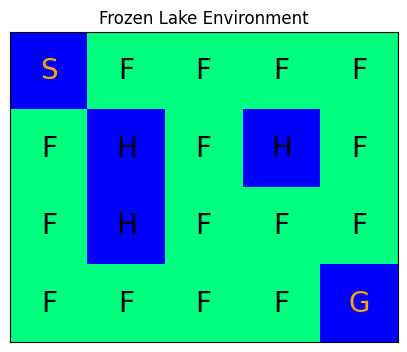

In [102]:
# Register the custom Frozen Lake environment
gym.envs.registration.register(
    id="CustomFrozenLake-v0",
    entry_point=__name__ + ":CustomFrozenLakeEnv",
)

# Create the environment
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)
env = env.unwrapped

# Plot the environment
plot_environment(env)

### Run Policy Iteration

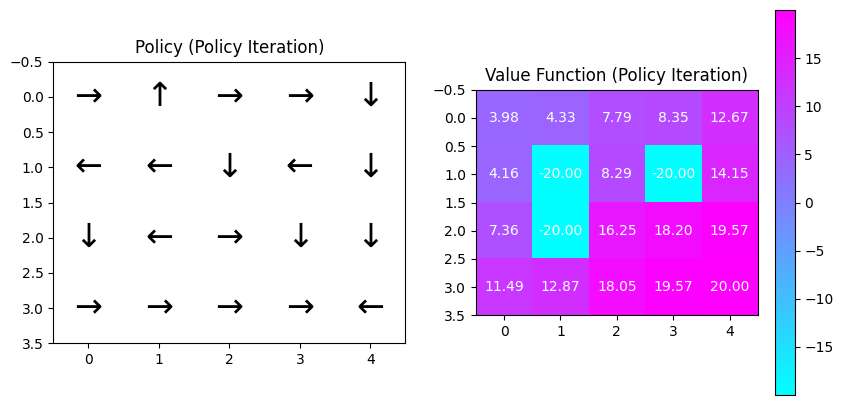

In [103]:
start_time_pi = time.time()
policy_pi, V_pi, iterations_pi = policy_iteration(env)
end_time_pi = time.time()
#plot_value_function(V_pi, title="Value Function (Policy Iteration)")
#plot_policy(policy_pi, title="Policy (Policy Iteration)")
plot_policy_and_value_function(policy_pi, V_pi, algorithm_name="Policy Iteration")

**Results - Policy Iteration**

*Policy plot*

The policy plot shows the optimal action to take from each state.
The optimal path seems to guide the agent from the start state (S) to the goal state (G) while avoiding the holes.


*Value Function plot*

The value function plot shows the expected cumulative reward starting from each state, following the optimal policy

**Interpretation**

- States with -20.00 correspond to the holes (H), indicating a high negative reward for falling into a hole.

- The goal state (G) has a high positive value (20.00), indicating the positive reward for reaching the goal.

- Other states have values indicating their desirability based on the optimal policy.

- The start state (0, 0) has a value of 3.98, reflecting the expected reward of starting there and following the optimal policy.

- States next to holes have lower values because of the risk of falling into a hole.

- States closer to the goal generally have higher values due to the positive reward associated with reaching the goal.


### Run Value Iteration

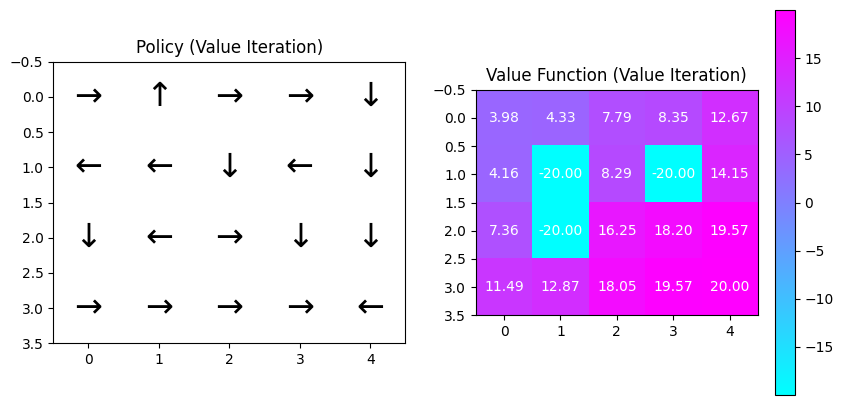

In [104]:
start_time_vi = time.time()
policy_vi, V_vi, iterations_vi  = value_iteration(env)
end_time_vi = time.time()
#plot_value_function(V_vi, title="Value Function (Value Iteration)")
#plot_policy(policy_vi, title="Policy (Value Iteration)")
plot_policy_and_value_function(policy_vi, V_vi, algorithm_name="Value Iteration")

Both algorithms have converged to the same optimal policy and value function for the given Frozen Lake environment


 **Optimal Policy**:

    - Both algorithms have identified the same optimal actions for each state in the Frozen Lake grid.

    - This means that the sequence of actions (arrows in the policy plot) that the agent should follow to maximize its cumulative reward is the same regardless of whether policy iteration or value iteration is used.

 **Optimal Value Function**:

    - Identical value functions from both algorithms indicate that they have both accurately estimated the same expected rewards for each state.

  The identical results provide confidence in the consistency and correctness of the implementations of both iterations

#### Policy iteration and Value iteration comparison

In [105]:
print(f"Policy Iteration completed in {iterations_pi} iterations.")
print(f"Value Iteration completed in {iterations_vi} iterations.\n")
print(f"Time taken for Policy Iteration: {end_time_pi - start_time_pi:.4f} seconds.")
print(f"Time taken for Value Iteration: {end_time_vi - start_time_vi:.4f} seconds.")

Policy Iteration completed in [361, 361, 361] iterations.
Value Iteration completed in 361 iterations.

Time taken for Policy Iteration: 0.0577 seconds.
Time taken for Value Iteration: 0.0525 seconds.


**Interpretation**

- Iterations: Policy iteration repeats the policy_evalution() iterations 3 times.

- Time: Both methods take roughly the same amount of time in this case, though value iteration is slightly slower overall.

## Run Monte Carlo GLIE

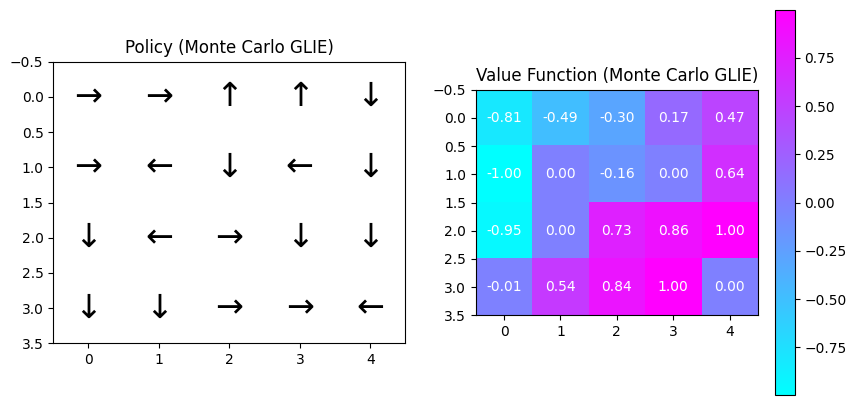

In [113]:
policy_mc, Q_mc = monte_carlo_glie(env)
#plot_value_function(np.max(Q_mc, axis=1), title="Value Function (Monte Carlo GLIE)")
#plot_policy(policy_mc, title="Policy (Monte Carlo GLIE)")
plot_policy_and_value_function(policy_mc, np.max(Q_mc, axis=1), algorithm_name="Monte Carlo GLIE")
plot_action_value_function(Q_mc, algorithm_name="Monte Carlo GLIE")

*Value Function (Right Plot)*

- The values range from around -0.82 to 1.00.
- The goal state and holes have a value of 0.00, indicating that these are terminal states.
- Higher values near the goal state indicate the agent's success in reaching the goal.
- Negative values or lower values near holes reflect the penalties associated with falling into holes.


**Understanding the Action-Value Function \( Q(s, a) \)**

*States and Actions*
   - The environment has 20 states, likely corresponding to a flattened version of the 4x5 grid of the Frozen Lake problem.
   - There are 4 possible actions in each state: up, down, left, and right.

Higher values indicate better actions for the given states.
   

**Comparison with Policy Iteration and Value Iteration**

*Policy Differences:*

- Policy Iteration & Value Iteration: Policies are more structured and consistent, showing clear optimal paths to the goal while avoiding holes.

- Monte Carlo GLIE: Policies can be less consistent due to the stochastic nature of sampling, showing more variability in the actions selected for each state.

*Value Function Differences:*

- Policy Iteration & Value Iteration: Values range higher (from -20 to 20), indicating precise estimation of cumulative rewards and penalties.
- Monte Carlo GLIE: Values range lower (from -0.82 to 1.00), reflecting more approximate estimates due to sampling variability.

## Run SARSA



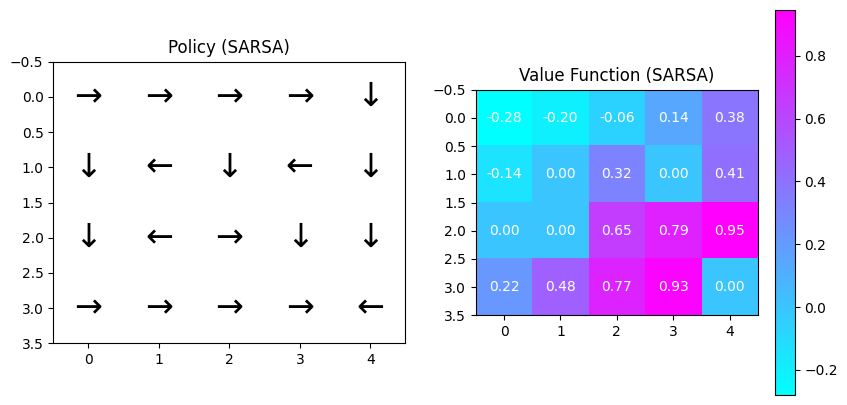

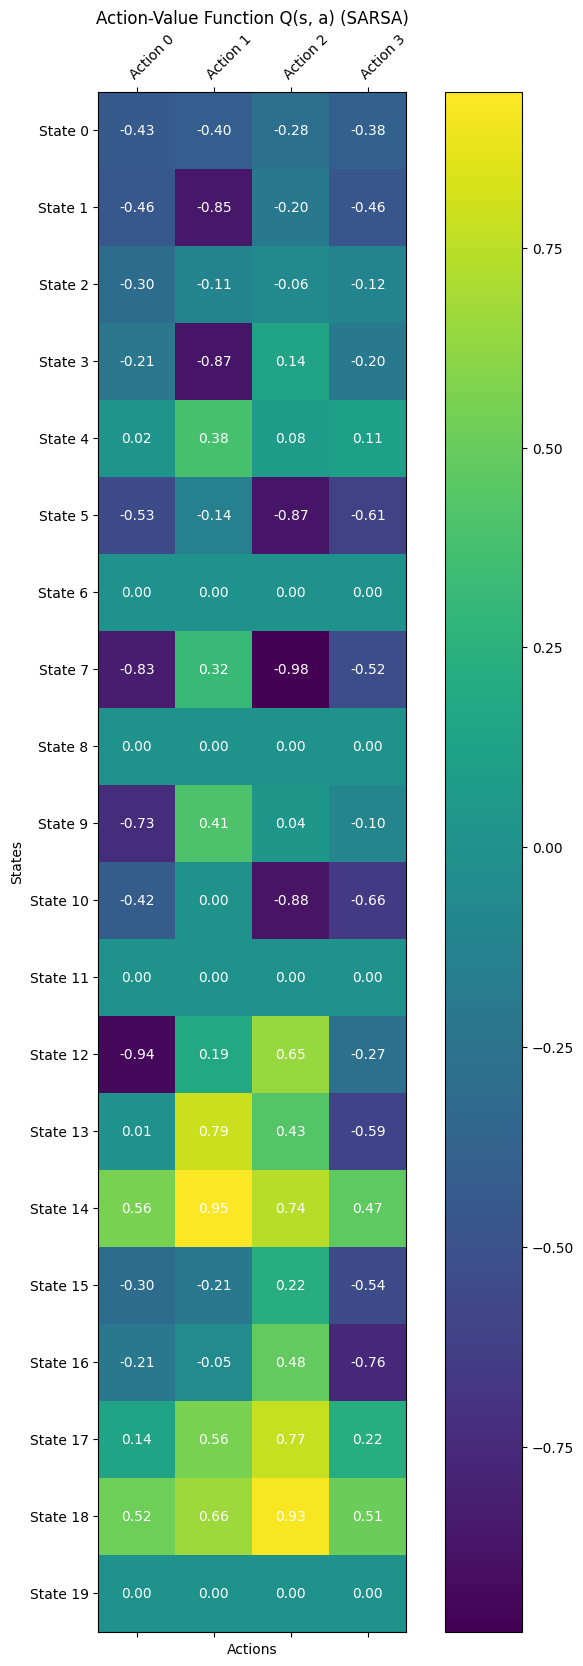

In [111]:
policy_sarsa, Q_sarsa, mean_rewards_sarsa = sarsa(env)
#plot_value_function(np.max(Q_sarsa, axis=1), title="Value Function (Sarsa)")
#plot_policy(policy_sarsa, title="Policy (Sarsa)")
plot_policy_and_value_function(policy_sarsa, np.max(Q_sarsa, axis=1), algorithm_name="SARSA")
plot_action_value_function(Q_sarsa, algorithm_name="SARSA")

## Run Q-Learning

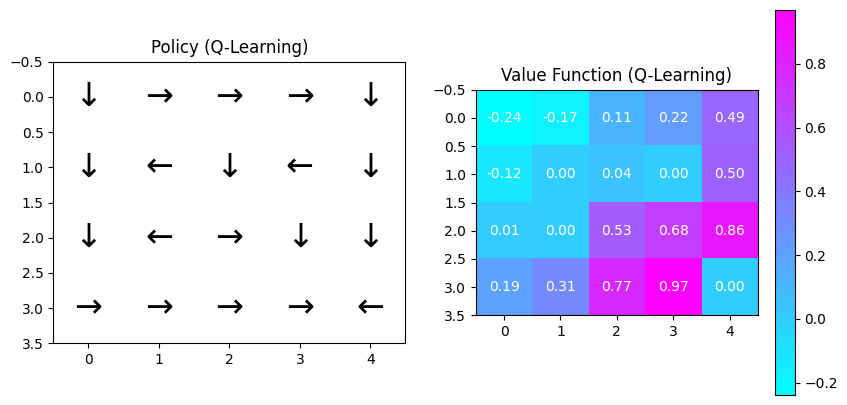

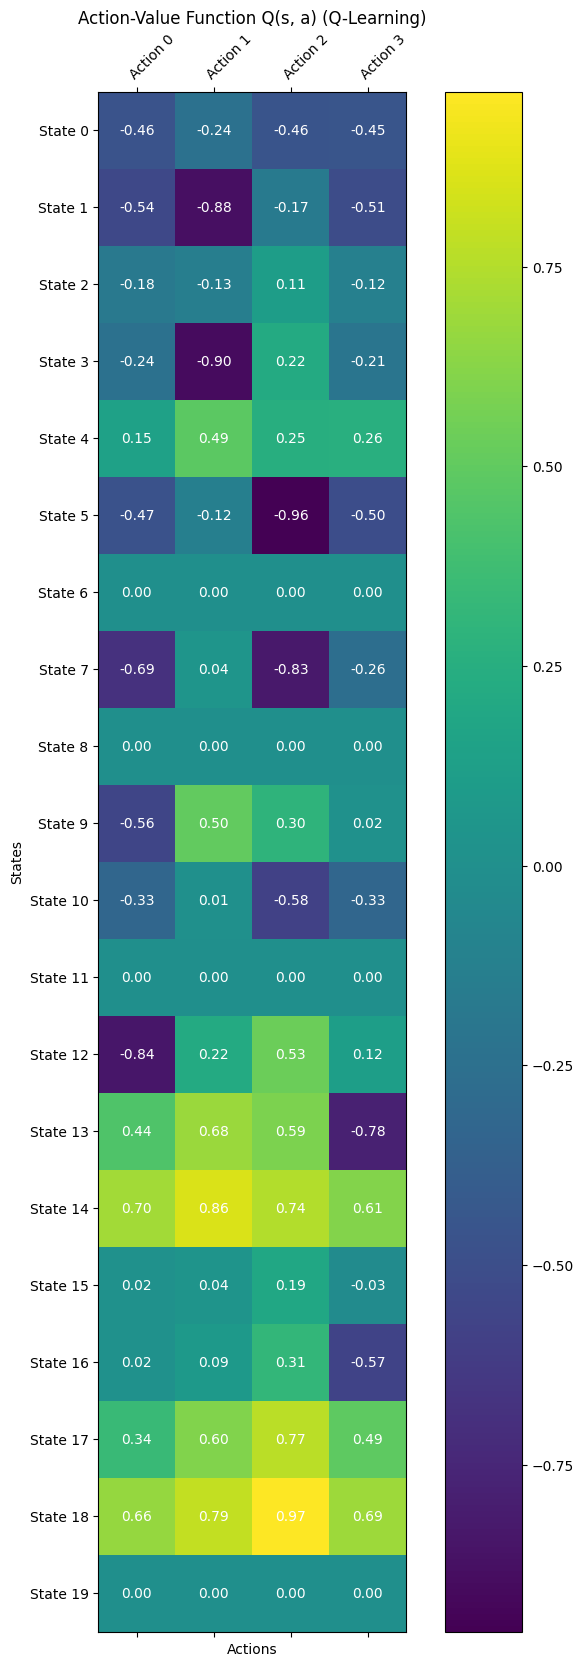

In [112]:
policy_q_learning, Q_q_learning, mean_rewards_q_learning = Q_learning(env)
#plot_value_function(np.max(Q_q_learning, axis=1), title="Value Function (Q-Learning)")
#plot_policy(policy_q_learning, title="Policy (Q-Learning)")
plot_policy_and_value_function(policy_q_learning, np.max(Q_q_learning, axis=1), algorithm_name="Q-Learning")
plot_action_value_function(Q_q_learning, algorithm_name="Q-Learning")

# Compare SARSA And Q-Learning average rewards

In [114]:
print(f"SARSA: Average Reward: {mean_rewards_sarsa}")
print(f"Q-Learning: Average Reward: {mean_rewards_q_learning}")

SARSA: Average Reward: -0.43918383676735345
Q-Learning: Average Reward: -0.4690778155631126
